# Sentiment Analysis of Twitter Feeds to Find Your Favorite Airline
CS109 Final Project:
Nicholas Ruta, Ayin Mokrivala, and Anna Whitney

We created a Python script to collect raw data from the Twitter Streaming API:

In [5]:
#MUST ADD YOUR TWITTER DEVELOPER CREDENTIALS FIRST
#you can rename this cell as get_twitter.py and run from the command line using this command - 
# python get_twitter.py > twitter_data.txt

#Import the necessary methods from the tweepy library
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

#Set the twitter developer credentials to access the Twitter Streaming API
access_token = ""
access_token_secret = ""
consumer_key = ""
consumer_secret = ""

#This is a basic listener that prints received tweets to stdout.
class StdOutListener(StreamListener):

    def on_data(self, data):
        print data
        return True

    def on_error(self, status):
        print status

        
#THIS SECTION IS COMMENTED OUT SINCE THE DEVELOPER CREDENTIALS ARE NOT IN PLACE ABOVE
# if __name__ == '__main__':

    #This handles Twitter authetification and the connection to Twitter Streaming API
#     l = StdOutListener()
#     auth = OAuthHandler(consumer_key, consumer_secret)
#     auth.set_access_token(access_token, access_token_secret)
#     stream = Stream(auth, l)

    #Use the filter to capture data from the stream by keywords -
#     stream.filter(track=['@united', '@AlaskaAir', '@FlyFrontier', '@HawaiianAir', '@VirginAmerica','@SouthwestAir','@Delta','@JetBlue','@SpiritAirlines','@AmericanAir','#united', '#AlaskaAir', '#FlyFrontier', '#HawaiianAir', '#VirginAmerica','#SouthwestAir','#Delta','#Jetblue','#SpiritAirlines','#AmericanAir'], async=True)

We combined all of the .txt files of raw data created from the above script into one clean and final .json file:

In [6]:
# #Uncomment if you want to combine .txt files from the above twitter streaming api process. 

# #take in the combined/entire dataset of json rows 
# #remove blank lines and only write the row to the 'cleanfile.json' file if it is valid JSON

# import json
# import fileinput
# import glob

# a function to verify that a row in the raw data file is valid JSON. We noticed that the Twitter Streaming API 
# did occasionally return data in error and had to take this step to clean the dataset
# def is_json(myjson):
#   try:
#     json_object = json.loads(myjson)
#   except ValueError, e:
#     return False
#   return True

# the glob library makes it easy to grab all of the text files we placed in a tweets folder
# these were the entire collection of raw data we brought in from the Twitter Streaming API over the Nov-Dec 2015 
# timeframe. 
# file_list = glob.glob("tweets/*.txt")
# combined_file_name = 'combined_result.json'


# with open(combined_file_name, 'w') as file:
#     input_lines = fileinput.input(file_list)
#     file.writelines(input_lines)
    

# f = open('clean_final_file.json','w')
# for line in open(combined_file_name):
#   line = line.rstrip()
#   if line != '':
#         if is_json(line) is True:      
#             f.write(line + "\n") # python will convert \n to os.linesep
# f.close() # you can omit in most cases as the destructor will call it

Our project focuses on analyzing the text of over 100,000 tweets about airlines using sentiment analysis and LDA to determine which airline receives the most positive or negative attention on Twitter, and what topics people are happy or sad about with regards to each airline.

We start by importing the modules we need.

In [1]:
import json
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

The Twitter Streaming API returns JSON objects. We took the resulting JSON and used the Python libraries json and pandas to create a list of 'raw_data' to be used in our text processing and visualizations. Our data can be downloaded from [Dropbox](https://www.dropbox.com/s/02gcmy6ftezmt23/tweets_all%40%23_103653.json?dl=0), and the below assumes that the JSON file containing the data is placed in the directory above the directory containing this notebook.

In [2]:
#create a file to contain the 'raw data' from the twitter streaming api
raw_data_path = '../tweets_all@#_103653.json'

#create a list to hold the tweets
raw_data = []

#create and open the new file
tweets_file = open(raw_data_path, "r")

#append to the tweets list from the raw data file
for line in tweets_file:
    try:
        tweet = json.loads(line)
        raw_data.append(tweet)
    except:
        continue       
print "Number of raw data rows - ", len(raw_data)
print "\n"
print "Here is what a JSON row in the raw data from the Twitter Streaming API looks like - "
print "\n"
print raw_data[0]

Number of raw data rows -  103653


Here is what a JSON row in the raw data from the Twitter Streaming API looks like - 


{u'contributors': None, u'truncated': False, u'text': u'#United States Football Tickets\xa0News https://t.co/82wIUcjYt6 https://t.co/cyGk7msfUQ', u'is_quote_status': False, u'in_reply_to_status_id': None, u'id': 671312538764599296, u'favorite_count': 0, u'source': u'<a href="http://publicize.wp.com/" rel="nofollow">WordPress.com</a>', u'retweeted': False, u'coordinates': None, u'timestamp_ms': u'1448888356282', u'entities': {u'user_mentions': [], u'symbols': [], u'hashtags': [{u'indices': [0, 7], u'text': u'United'}], u'urls': [{u'url': u'https://t.co/82wIUcjYt6', u'indices': [37, 60], u'expanded_url': u'http://buyfootballtickets.xyz/index.php/2015/11/30/united-states-football-tickets-news-37/', u'display_url': u'buyfootballtickets.xyz/index.php/2015\u2026'}], u'media': [{u'expanded_url': u'http://twitter.com/rvtkq_t/status/671312538764599296/photo/1', u'display_ur

In [3]:
tweets = pd.DataFrame()

We took the raw data from the Twitter Streaming API and placed it in a Pandas Dataframe. There are many fields provided by the Twitter API, we used the Python library map function with a lambda to set pandas df columns for each of the fields of potential interest. To maintain a clean df, we set the value to 'None' in places where there is no value returned by the Twitter Streaming API:

In [4]:
#removed u'possibly_sensitive', at the moment since not all rows have it
#it goes between place and retweet_count in the below list
twitter_fields = [u'contributors', u'coordinates', u'created_at', u'entities', 
                  u'favorite_count', u'favorited', u'filter_level', u'geo', u'id',
                  u'id_str', u'in_reply_to_screen_name', u'in_reply_to_status_id', 
                  u'in_reply_to_status_id_str', u'in_reply_to_user_id', u'in_reply_to_user_id_str', 
                  u'lang', u'place',   u'retweet_count', u'retweeted', u'source', 
                  u'text', u'timestamp_ms', u'truncated', u'user']

#set the columns in the dataframe to match the json fields of the twitter streaming api
for t in twitter_fields:
    tweets[t] = map(lambda tweet: tweet[t] if tweet[t] else 'None', raw_data)
tweets['followers_count'] = map(lambda tweet: tweet['user']['followers_count'] if tweet['user'] != None else None, raw_data)
tweets['country'] = map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, raw_data)

We will use many of these fields to do our analysis, draw interesting conclusions and visualize. For example, we are interested to find out how positive the sentiment of tweets from twitter users with the highest follower_counts is. We wondered if the top twitter users are paid to be positive and we wanted to see if the data reflects this possibility: 

In [5]:
print "We can see the how many people are following the user of each tweet in the dataset - "
print tweets['followers_count'].head()

print "\n"

print "And it will be important to verify that the majority of the data is in American English since that is what we will be basing our sentiment analysis on -"
print tweets['lang'].head()

We can see the how many people are following the user of each tweet in the dataset - 
0      48
1    2234
2      16
3      35
4    1672
Name: followers_count, dtype: int64


And it will be important to verify that the majority of the data is in American English since that is what we will be basing our sentiment analysis on -
0    en
1    en
2    en
3    en
4    en
Name: lang, dtype: object


Now that we have collected the raw data and placed it in a pandas dataframe, let's take a look at some of the tweets text specifically:

In [6]:
#View the first 5 tweets of the dataset
pd.set_option('max_colwidth', 200)
tweets['text'].head(5)

0                      #United States Football Tickets News https://t.co/82wIUcjYt6 https://t.co/cyGk7msfUQ
1    In fact I have rarely in my entire life (if ever?) felt more bamboozled by an airline. @SpiritAirlines
2                      #United States Football Tickets News https://t.co/USYm8mOueG https://t.co/35eZEfycvB
3                      #United States Football Tickets News https://t.co/SFVIa6D9dg https://t.co/owpvznBCrA
4                                       Complimentary #Citrix CTP WiFi on @Delta flight, always a pleasure!
Name: text, dtype: object

It is important to verify that the majority of the tweets are in American English since the sentiment analysis will depend on it. We are using a word list that weighs certain key nouns/adjectives based on the sentiment associated with them. It assumes American English is passed to it.

We used a histogram to verify the top language as English: 

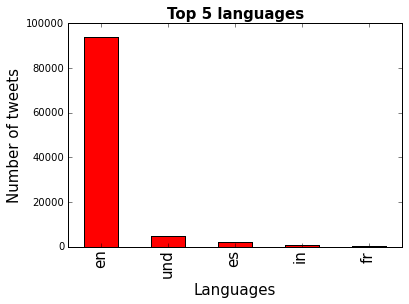

In [7]:
#view the top 5 languages present in the dataset
tweets_by_lang = tweets['lang'].value_counts()
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')

and another histogram to verify that the tweets are mostly from the USA:

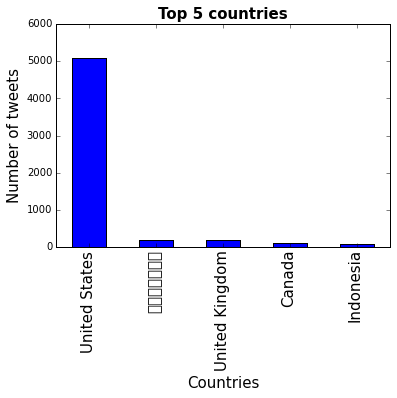

In [8]:
#view the top 5 countries in the dataset
tweets_by_country = tweets['country'].value_counts()
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 countries', fontsize=15, fontweight='bold')
tweets_by_country[:5].plot(ax=ax, kind='bar', color='blue')

We wanted to see how many tweets were about each of the top ten that we selected for the project. First, we create a function to find a word in the tweet text column of the pandas dataframe we created:

In [9]:
import re
#create a function to find the word in the tweet text field
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False

and then we used that function, word_in_text, to create new columns for each airline and include the total count for each:

In [10]:
#get the words in the text
airlines = ['southwest', 'delta', 'jetblue', 'united', 'flyfrontier', 'hawaiianair', 'virginamerica', 'alaskaair','spiritairlines', 'AmericanAir']

#create columns for each airline and set a boolean value to use for the below visualization of tweet count 
#for each airline
for a in airlines:
    if (tweets['text'].apply(lambda tweet: word_in_text(a, tweet))).count() > 0:
        tweets[a] = tweets['text'].apply(lambda tweet: word_in_text(a, tweet))

We can get the total count by adding up all of the rows, for a particular airline column of the dataframe, that have a True value. For example, here is the total count for Southwest Airline:

In [11]:
print len(tweets.loc[tweets['southwest'] == True])

11204


We get those counts for all of those airlines and plot to see the comparison:

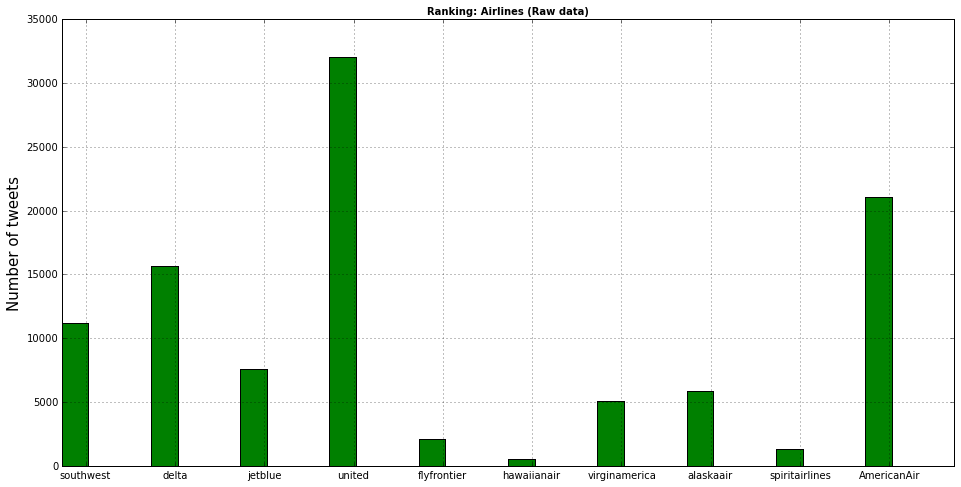

In [12]:
#view the amount of tweets per airline
tweets_by_airlines = [len(tweets.loc[tweets['southwest'] == True]), 
 len(tweets.loc[tweets['delta'] == True]), len(tweets.loc[tweets['jetblue'] == True]),
         len(tweets.loc[tweets['united'] == True]), len(tweets.loc[tweets['flyfrontier'] == True]),
                     len(tweets.loc[tweets['hawaiianair'] == True]),len(tweets.loc[tweets['virginamerica'] == True]),
                     len(tweets.loc[tweets['alaskaair'] == True]),len(tweets.loc[tweets['spiritairlines'] == True]),
                     len(tweets.loc[tweets['AmericanAir'] == True])]

airlines = ['southwest', 'delta', 'jetblue', 'united', 'flyfrontier', 'hawaiianair', 'virginamerica', 'alaskaair','spiritairlines', 'AmericanAir']

x_pos = list(range(len(airlines)))
width = 0.3
fig, ax = plt.subplots(figsize=(16,8))
plt.bar(x_pos, tweets_by_airlines, width, alpha=1, color='g')
# Setting axis labels and ticks
ax.set_ylabel('Number of tweets', fontsize=15)
ax.set_title('Ranking: Airlines (Raw data)', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.9 * width for p in x_pos])
ax.set_xticklabels(airlines)
plt.grid()

We will need a new column for the dataframe called 'airline'. We created this for our spark text processing and LDA Topic modelling in addition to the visualizations we will create:

In [13]:
#create a dataframe called 'processed_data' with extra column 'airline'

#a function to set the airline name where the column value is True
def setAirlineName(row):   
    x = None
    for a in airlines:
        if row[a] is True:
            x = a
    if x is not None:
        return x
    else: 
        return

# set a column in the tweets dataframe for each airline name with a boolean value
for a in airlines:
    if (tweets['text'].apply(lambda tweet: word_in_text(a, tweet))).count() > 0:
        tweets[a] = tweets['text'].apply(lambda tweet: word_in_text(a, tweet))

#add the airline column with the airline name as the value 
tweets['airline'] = tweets.apply(lambda row: setAirlineName(row), axis=1)  

#remove the temp. columns for each airline
for a in airlines:
    tweets = tweets.drop(a, 1)

#filter to just English-language tweets, since all our language processing is English-specific
processed_data = tweets[tweets['lang'] == 'en']

#processed_data['airline'] values are - 'southwest', 'delta', 'jetblue', 'united', 'flyfrontier', 
# 'hawaiianair', 'virginamerica', 'alaskaair','spiritairlines', 'AmericanAir'
print 'The Processed Data File contains', len(processed_data), 'tweets.'

The Processed Data File contains 93737 tweets.


This new dataframe contains the 'airline' column we need:

In [14]:
processed_data['airline'].head()

0            united
1    spiritairlines
2            united
3            united
4             delta
Name: airline, dtype: object

At one point, we thought it would be necessary to have a JSON file created from this new dataframe. We created a script to do that but eventually decided to use the dataframe directly in the Spark text processing application:

In [12]:
#create a json file from the processed_data pandas dataframe
#it has the extra airline field that will be used for spark processing

#This is commented out since we are using the processed_data dataframe for the spark processing
# with open('processed_data.json', 'w') as outfile:  
#     for index, row in processed_data.iterrows():
#         outfile.write(row.to_json())
#         outfile.write('\n')

# Pass the data with airlines to Spark for text processing

In [15]:
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
from sklearn.feature_extraction import text
from gensim import corpora 

In [16]:
import findspark
findspark.init()
print findspark.find()

/usr/local/opt/apache-spark/libexec


In [17]:
import pyspark

In [18]:
# adapted from HW5
def get_parts(thetext, punc='.,;:!?()[]{}`''\"@#$^&*+-|=~_'):
    # generate stopwords list & regexes for 2+ periods or 2+ dashes
    stop = text.ENGLISH_STOP_WORDS
    regex1=re.compile(r"\.{2,}")
    regex2=re.compile(r"\-{2,}")
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    punctuation = list(punc)
    nouns=[]
    descriptives=[]
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        nouns.append([])
        descriptives.append([])
        for token in sentence:
            if len(token[4]) >0:
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    if token[4] in stop or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    descriptives[i].append(token[4])
                elif token[1] in ['NN', 'NNS']:
                    if token[4] in stop or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns[i].append(token[4])
    out=zip(nouns, descriptives)
    nouns2=[]
    descriptives2=[]
    for n,d in out:
        if len(n)!=0 and len(d)!=0:
            nouns2.append(n)
            descriptives2.append(d)
    return nouns2, descriptives2

In [19]:
# initialize Spark context
conf = pyspark.SparkConf().setAppName("Twitter_Airline").setMaster("local[*]")
sc = pyspark.SparkContext(conf=conf)

We read all the tweets from the dataframe into Spark, assigning each tweet a unique ID so we can track it through our sentiment analysis and LDA topic modeling.

In [20]:
# read tweets & associated airlines into Spark
tweets_text = sc.parallelize([(row['airline'], row['text']) for index, row in processed_data.iterrows()]).zipWithIndex().map(lambda ((air, txt), idx): ((idx, air), txt))
tweets_text.take(5)

[((0, 'united'),
  u'#United States Football Tickets\xa0News https://t.co/82wIUcjYt6 https://t.co/cyGk7msfUQ'),
 ((1, 'spiritairlines'),
  u'In fact I have rarely in my entire life (if ever?) felt more bamboozled by an airline. @SpiritAirlines'),
 ((2, 'united'),
  u'#United States Football Tickets\xa0News https://t.co/USYm8mOueG https://t.co/35eZEfycvB'),
 ((3, 'united'),
  u'#United States Football Tickets\xa0News https://t.co/SFVIa6D9dg https://t.co/owpvznBCrA'),
 ((4, 'delta'),
  u'Complimentary #Citrix CTP WiFi on @Delta flight, always a pleasure!')]

### Sentiment of a sentence based on log probs in a word list

Function to read the word list file:

In [21]:
import numpy as np
# read the word list
def readSentimentList(file_name):
    ifile = open(file_name, 'r')
    happy_log_probs = {}
    sad_log_probs = {}
    ifile.readline() #Ignore title row
    # splitting the csv
    for line in ifile:
        tokens = line[:-1].split(',')
        happy_log_probs[tokens[0]] = float(tokens[1])
        sad_log_probs[tokens[0]] = float(tokens[2])

    return happy_log_probs, sad_log_probs

Using Naive Bayes rule:

In [22]:
def classifySentiment(words, happy_log_probs, sad_log_probs):
    # get the log-probability of each word under each sentiment
    happy_probs = [happy_log_probs[word] for word in words if word in happy_log_probs]
    sad_probs = [sad_log_probs[word] for word in words if word in sad_log_probs]

    # sum all the log-probabilities for each sentiment to get a log-probability for the whole tweet
    tweet_happy_log_prob = np.sum(happy_probs)
    tweet_sad_log_prob = np.sum(sad_probs)

    # calculate the probability of the tweet belonging to each sentiment
    prob_happy = np.reciprocal(np.exp(tweet_sad_log_prob - tweet_happy_log_prob) + 1)
    prob_sad = 1 - prob_happy

    return prob_happy, prob_sad

Load the word list:

In [23]:
# load list of words and log probs
happy_log_probs, sad_log_probs = readSentimentList('wordlist.csv')

Reading in the tweet:

In [24]:
# read tweet
tweet1 = ['my', 'hate', 'southwest']

# calculate the probability
tweet1_happy_prob, tweet1_sad_prob = classifySentiment(tweet1, happy_log_probs, sad_log_probs)

print tweet1 
print "happy probability: " , tweet1_happy_prob 
print "sad probability:", tweet1_sad_prob

['my', 'hate', 'southwest']
happy probability:  0.280105168408
sad probability: 0.719894831592


In [25]:
# get words out for sentiment analysis
puncs = '.,;:!?()[]{}`''\"@#$^&*+-|=~_'
sentiment_words = tweets_text.mapValues(lambda t: t.strip(puncs).split())

# classify sentiment of tweet
tweets_probs = sentiment_words.mapValues(lambda ws: classifySentiment(ws, happy_log_probs, sad_log_probs))
happy_probs = tweets_probs.mapValues(lambda (hprob, sprob): (hprob, 1))
sad_probs = tweets_probs.mapValues(lambda (hprob, sprob): (sprob, 1))


Create an output.csv file to use for visualization 

In [26]:
#collect the happy probabilities from the above mapValues call
listOfHappyProbs = happy_probs.collect()

#create an empty list to contain the just the probability portion of happy_probs
HappyProbsList = []
for x in range(len(listOfHappyProbs)):
    HappyProbsList.append(listOfHappyProbs[x][1][0])

#create the following dataframe containing columns of data for visualization
# text, airline, positive, prob, created_at, favorite_count, retweet_count, followers_count
df_data_visualization = pd.DataFrame()
df_data_visualization['created_at'] = processed_data['created_at']
df_data_visualization['favorite_count'] = processed_data['favorite_count']
df_data_visualization['retweet_count'] = processed_data['retweet_count']
df_data_visualization['followers_count'] = processed_data['followers_count']
# df_data_visualization['text'] = processed_data['text']
df_data_visualization['airline'] = processed_data['airline']
df_data_visualization['prob'] = HappyProbsList

#a function to set a 1 if the happy probability is greater than .5 otherwise set it to 0
#we will use this for the visualization aspect
def setPositiveValues(row):
    if row['prob'] > 0.5:
        return 1
    else:
        return 0

#run the function on the prob column to create the positive column to determine if a tweet is positive or negative
#from the happy probability
df_data_visualization['positive'] = df_data_visualization.apply(setPositiveValues, axis=1)

#create the text column, remove the newlines from the text to resolve an issue with row creation in the .to_csv call
df_data_visualization['text'] = processed_data['text'].str.replace('\n',"")

#create a .csv file to use for visualization 
df_data_visualization.to_csv('output.csv', encoding='utf-8', index=False)

## Visualization

reading hte output file

In [27]:
df = pd.read_csv("output.csv")
#df.to_csv("output.csv", date_format='%Y%m%d')
#getting rid of undecided tweets
df = df[(df.prob <> .5)]
df.head()

,created_at,favorite_count,retweet_count,followers_count,airline,prob,positive,text
1,Mon Nov 30 12:59:18 +0000 2015,None,None,2234,spiritairlines,0.959401,1,In fact I have rarely in my entire life (if ever?) felt more bamboozled by an airline. @SpiritAirlines
4,Mon Nov 30 12:59:49 +0000 2015,None,None,1672,delta,0.987388,1,"Complimentary #Citrix CTP WiFi on @Delta flight, always a pleasure!"
5,Mon Nov 30 13:00:02 +0000 2015,None,None,189,AmericanAir,0.873072,1,@judsonabts @AmericanAir the thing about it is they were my carry ons...
10,Mon Nov 30 13:00:37 +0000 2015,None,None,16720,virginamerica,0.797083,1,.@United responds to @VirginAmerica entering #Denver - San Francisco market https://t.co/P47FlIPWXy https://t.co/et2OeZSZCe
11,Mon Nov 30 13:00:40 +0000 2015,None,None,16,AmericanAir,0.955934,1,@AmericanAir another flight with American and again a super cramped seat. It's not an airplane it's a Sardine Can it seems like it.


Running Plotly

In [28]:
#run these using your username and key
import plotly.tools as tls
tls.set_credentials_file(username='ayinmv', api_key='rq66z3hqx8')

import plotly.plotly as py
from plotly.graph_objs import *

#install cufflink package
import cufflinks as cf
print cf.__version__

0.7.1


Number of Tweets

In [29]:
airline_count = df.groupby(['airline']).count().prob.sort_values(axis=0, ascending=False, inplace=False)
airline_count.iplot(kind='bar', yTitle='Number of Tweets', title='Number of Tweets')

tls.embed('https://plot.ly/~ayinmv/33')

Score of the airlines based on the average of their positive scores

In [30]:
airline_count = df.groupby(['airline']).mean().prob.sort_values(axis=0, ascending=False, inplace=False)
airline_count.iplot(kind='bar', yTitle='Average Score', title='Average Score')

tls.embed('https://plot.ly/~ayinmv/63')

Most important tweets

In [31]:
pd.set_option('max_colwidth', 200)

df.sort_values(by=['followers_count'], ascending=[False])[['followers_count','text', 'prob', 'created_at']].head(20)

,followers_count,text,prob,created_at
80284,9561279,@beauflynn @VirginAmerica Yea baby! Fav airline to fly outta FLL. Safe travels bro great seeing you,0.999871,Sun Nov 29 02:58:52 +0000 2015
26101,4546595,A couple teammates took in a different form of elite training during the off-day in Atlanta at @Delta​ HQ: https://t.co/pDpWK0aeKc,0.993440,Thu Dec 03 23:39:13 +0000 2015
30012,3313970,@AmericanAir thank you for the concierge key this year! hope i get renewed for 2016!,0.998328,Fri Dec 04 08:55:41 +0000 2015
29971,3313940,me &amp; @R3HAB waited until our row fell asleep then made a lil banger here on @americanair studios.,0.960900,Fri Dec 04 08:46:26 +0000 2015
27211,3068510,Had the best time spreading cheer today @delta's Holiday in the Hangar event! Check out this winter wonderland! #DeltaLAX #DeltaGreaterGood,0.997183,Fri Dec 04 01:39:24 +0000 2015
84167,2042736,"Apparently "" sully "" the service dog who weighs at least 50 pounds is having trouble getting comfortable in business class @Delta",0.998998,Sun Nov 29 16:43:22 +0000 2015
68221,1974653,"@kristina_vash @VirginAmerica So sorry to hear it! As mentioned, the seats are under airport control. We appreciate you working with us.",0.993639,Tue Dec 08 23:19:05 +0000 2015
68158,1974652,"@kristina_vash @VirginAmerica This has happened before, Kristina?",0.387029,Tue Dec 08 23:11:16 +0000 2015
66893,1974645,Tag @JetBlue &amp; #IChipInSweepstakes for a chance to win $1K for your charity of choice.+Terms https://t.co/gRnM9IVJhs https://t.co/AglRia4LWb,0.986362,Tue Dec 08 21:30:07 +0000 2015
65810,1974642,@JoJensen Her best source for info is the JFK Baggage Service Office. Ph: 1-347-545-3900 Email: jfklostandfound@jetblue.com,0.994583,Tue Dec 08 20:15:55 +0000 2015


Pulling groupby airline output

In [32]:
dfgroupby = pd.read_csv("outputgroupby.csv")
dfgroupby.head()

,alaskaair,AmericanAir,delta,flyfrontier,hawaiianair,jetblue,southwest,spiritairlines,united,virginamerica
0,0.993208,0.873072,0.987388,0.997226,0.931447,0.952768,0.996007,0.959401,0.886928,0.797083
1,0.965431,0.955934,0.830840,0.998100,0.805865,0.959188,0.591763,0.753549,0.999895,0.797083
2,0.712421,0.926986,0.729272,0.976348,0.374371,0.801286,0.966923,0.989527,0.998912,0.921270
3,0.758827,0.878757,0.986554,0.967824,0.712421,0.958959,0.957541,0.874128,0.992084,0.597163
4,0.996239,0.953406,0.986554,0.954536,0.798882,0.984909,0.872952,0.962676,0.999378,0.597163


Quantile plot

In [33]:
dfgroupby.iplot(kind='box', title='Score Quantiles')

tls.embed('https://plot.ly/~ayinmv/78')

We can aggregate all the happy & sad probabilities for individual tweets about each airline into an average probability that users are happy or sad about that airline:

In [34]:
airline_happy_probs = happy_probs.map(lambda ((idx, air), probs): (air, probs)).reduceByKey(lambda (p1,num1),(p2,num2): ((num1*p1 + num2*p2)/(num1 + num2), num1 + num2)).mapValues(lambda (p, n): p) 
airline_sad_probs = sad_probs.map(lambda ((idx, air), probs): (air, probs)).reduceByKey(lambda (p1,num1),(p2,num2): ((num1*p1 + num2*p2)/(num1 + num2), num1 + num2)).mapValues(lambda (p, n): p) 
print "Happy probabilities:", airline_happy_probs.take(5)
print "Sad probabilities:", airline_sad_probs.take(5)

Happy probabilities: [('alaskaair', 0.84730711830993755), (None, 0.8068260437527468), ('hawaiianair', 0.85420674663501239), ('united', 0.7957213123058936), ('spiritairlines', 0.81506629154611132)]
Sad probabilities: [('alaskaair', 0.15269288169006007), (None, 0.19317395624725334), ('hawaiianair', 0.14579325336498758), ('united', 0.20427868769411134), ('spiritairlines', 0.18493370845388871)]


### LDA on nouns for topic analysis

We separate out the nouns from each tweet to feed into our LDA model, and create a gensim dictionary of all the nouns.

In [35]:
from operator import add

In [36]:
# parse nouns out of tweets
tweets_n_a = tweets_text.mapValues(get_parts)
tweets_nouns = tweets_n_a.mapValues(lambda (n, adj): n)
print tweets_nouns.take(5)
all_nouns = tweets_nouns.flatMapValues(lambda l: l).values().toLocalIterator()

# feed nouns into gensim
dictionary = corpora.Dictionary(all_nouns)
dictionary.filter_extremes()
dictionary.compactify()

[((0, 'united'), []), ((1, 'spiritairlines'), [[u'fact', u'life']]), ((2, 'united'), []), ((3, 'united'), []), ((4, 'delta'), [[u'flight', u'pleasure']])]


We then vectorize the nouns in each tweet (the first map is just to get our input in the form that gensim's doc2bow function wants, while the filter removes tweets that didn't contain any identifiable nouns).

In [37]:
doc_vecs = tweets_nouns.mapValues(lambda n: reduce(add, n, [])).filter(lambda (k, v): v).mapValues(dictionary.doc2bow)
corpus = doc_vecs.values().collect()

In [38]:
NUM_TOPICS = 100

We use Latent Dirichlet Allocation (LDA) from gensim to find latent topics within our tweets.

In [39]:
from gensim.models.ldamodel import LdaModel

In [40]:
lda = LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=5)

Printing the top topics, we can see the top terms associated with each topic and the "coherence score" of the topic, a measure of how closely related the terms in each topic are. 

The coherence score is calculated as:
$$C(t; V^{(t)}) = \sum_{m=2}^{M} \sum_{l=1}^{m-1} log \frac {D\left(v^{(t)}_m, v^{(t)}_l\right) + 1} {D\left(v^{(t)}_l\right)}$$
where $V^{(t)} = \left(v^{(t)}_1, ..., v^{(t)}_M\right)$ is a list of the $M$ most probable words for topic $t$, $D(v)$ is the document frequency of the word v, and $D(v, v')$ is the _co-document frequency_ of the words $v$ and $v'$, i.e., the number of documents in which both words appear (see [the original paper](http://people.cs.umass.edu/~wallach/publications/mimno11optimizing.pdf) for more details).

The coherence score thus measures roughly how likely it is that the words associated with a given topic are actually conceptually related to each other. The absolute score isn't terribly useful on its own, since the range of this function depends on the size of the corpus, length of documents, etc., but it's a useful way of ranking topics relative to each other on how likely they are to be informative. We thus take the top topics by coherence score to perform further analysis on.

In [41]:
best_topics = lda.top_topics(corpus)[:15]
for idx, tpc in enumerate(best_topics):
    print "Topic", idx, ":"
    print "    score:", tpc[1]
    print "    terms:", tpc[0][:10]

Topic 0 :
    score: -863.111591095
    terms: [(0.29778695721295056, u'deal'), (0.15886845547031164, u'yr'), (0.063497473853442801, u'dude'), (0.057161030056128839, u'standard'), (0.055802543212366336, u'honeymoon'), (0.050940919331319168, u'mountain'), (0.03959793393578908, u'sabokitty'), (0.034539818956493031, u'renoairport'), (0.033698379865137559, u'legend'), (0.03104540969834817, u'utd')]
Topic 1 :
    score: -877.204458065
    terms: [(0.24194480534440529, u'heritage'), (0.15679282356413729, u'support'), (0.068298764919991733, u'volunteer'), (0.066129530528565711, u'mess'), (0.041517113720019511, u'sex'), (0.039513020817545201, u'roll'), (0.029675488305593366, u'gov'), (0.029675488305593366, u'comfortwoman'), (0.029675488305593366, u'broker'), (0.028619575794805365, u'cyber')]
Topic 2 :
    score: -895.099914127
    terms: [(0.95564702474725838, u'flight'), (0.0073577824738268426, u'thanksgiving'), (0.0038022276437960374, u'jacket'), (0.0034975454783457332, u'netflix'), (0.00224

Even after sorting by coherence score, many of these topics do not obviously correspond to a particular human-identifiable concept. However, we do have Topic 8, which includes "bag", "suitcase", and "carousel" among its highest-probability terms, and Topic 7, which includes "cancellation" and "weather" [ADJUST FOR TOPICS ON FULL DATASET]. These give some indication of possible topics we might be interested in.

These ranks for the topics based on coherence score aren't the internal topic ids that gensim uses, though, so we have to find these internal ids for each of the topics in question.

In [42]:
all_topics = lda.show_topics(NUM_TOPICS, formatted=False)

In [43]:
def get_topic_id(topic, all_topics):
    """
    Matches the topics returned by top_topics to their ids in the LDA model
    by checking for term overlap.
    """
    for tpc in all_topics:
        if len(set([t[0] for t in tpc[1]]) & set([t[1] for t in topic[0]])) == 10:
            return tpc[0]

In [44]:
best_topics_ids = [get_topic_id(topic, all_topics) for topic in best_topics]
best_topics_ids

[91, 74, 88, 5, 17, 79, 71, 48, 19, 28, 23, 10, 45, 80, 7]

Now that we have a bunch of topics and we've assigned each tweet a probability of being "happy" or "sad" (i.e., expressing positive or negative sentiment), we can calculate what topics are most associated with positive or negative tweets.

We start by determining how likely each tweet is to be associated with each of our best topics.

In [45]:
def get_best_topics(bow):
    my_topics = lda.get_document_topics(bow)
    my_best_topics = [tpc for tpc in my_topics if tpc[0] in best_topics_ids]
    return my_best_topics

We only keep tweets that have a non-negligible likelihood of belonging to one of our top topics (using the filter statement below).

In [46]:
tweets_topics = doc_vecs.mapValues(get_best_topics).filter(lambda (k,v): v)
tweets_topics.take(5)

[((4, 'delta'), [(88, 0.33666666666666656)]),
 ((7, 'delta'), [(23, 0.25250000000000095)]),
 ((11, 'AmericanAir'), [(88, 0.33666666666666689)]),
 ((20, 'united'), [(71, 0.50499999999999989)]),
 ((21, 'delta'), [(48, 0.33666666666666689), (88, 0.33666666666644329)])]

We can pull out the correlation scores of each tweet to each topic and then plot a histogram for each topic showing its distribution of correlation scores.

In [47]:
# Get a list of all the tweets' correlation scores to each of our topics
scores_per_topic = tweets_topics.values().flatMap(lambda v: v).mapValues(lambda v: [v]).reduceByKey(add)
# Store it as a dict, keyed by the topic ID
hist_input = scores_per_topic.collectAsMap()

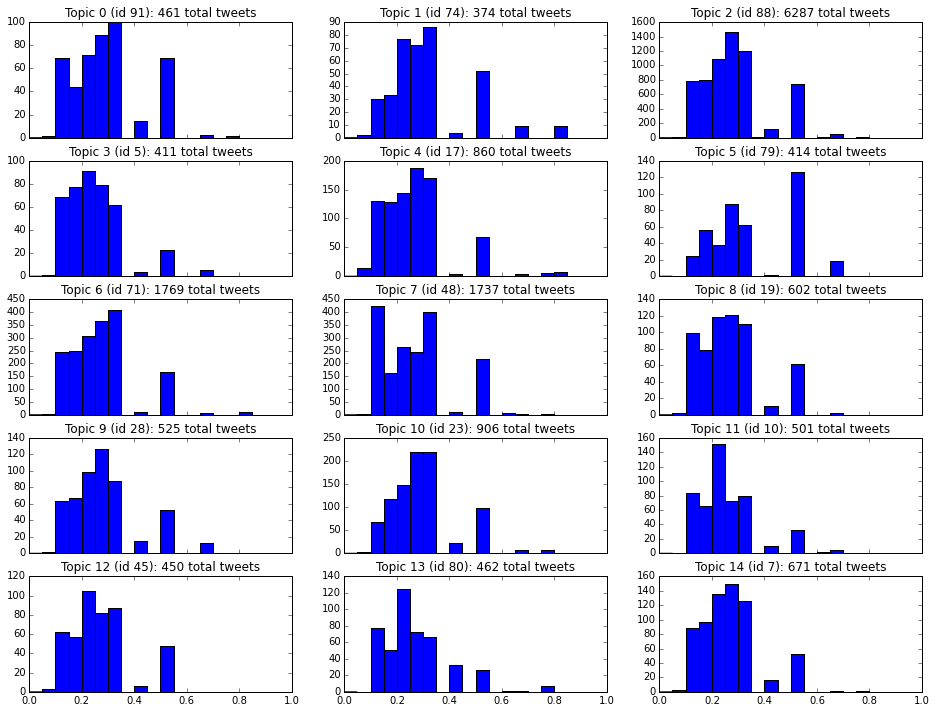

In [48]:
fig, axes = plt.subplots(5,3, sharex=True)
fig.set_size_inches(16, 12)
for idx, ax in enumerate(axes.ravel()):
    ax.hist(hist_input[best_topics_ids[idx]], 20, range=[0,1])
    ax.set_title('Topic {} (id {}): {} total tweets'.format(idx, best_topics_ids[idx], len(hist_input[best_topics_ids[idx]])))

For most topics, there are many tweets that are a little bit related to the topic, and fewer that the model says are very closely related to the topic. There also appears to be a disproportionate concentration of correlation scores in the 0.5 bin, particularly compared to the bins immediately surrounding it. This is likely due to a mathematical quirk of LDA, which is particularly visible because tweets are very short documents.

In general, the LDA topic model is not hugely confident in its assignment of individual tweets to topics. This is not surprising, because an individual tweet contains very few words (and even fewer nouns recognizable by the part-of-speech tagger, particularly given that tweets do not always follow standard grammatical structure), so there is not very much basis on which to assign a tweet to one topic or another. One way to improve this would be to use a part-of-speech tagger trained on a Twitter corpus, so that more information could be extracted from each tweet. However, 140 characters is never going to contain a huge number of words for the LDA model to base its topic assignment on, so automatic topic assignments of tweets are inherently going to be less certain than automatic topic assignments of longer documents.

Next, we combine our topic RDD with our sentiment RDD to convert the topics and sentiment scores associated with each tweet into sentiment scores associated with each topic, and with each topic-airline combination. We will weight a tweet's contribution to each topic's sentiment score by its correlation score to that topic.

In [49]:
# Join topics and sentiment probabilities by key
combined = tweets_topics.join(tweets_probs)
combined.take(5)

[((77854, 'virginamerica'),
  ([(80, 0.20200000000000021)], (0.93448827832145132, 0.065511721678548684))),
 ((43903, 'united'),
  ([(79, 0.50250000000000039)], (0.95717728750125242, 0.042822712498747584))),
 ((6729, 'AmericanAir'),
  ([(71, 0.25250000000000078)], (0.73027140441318139, 0.26972859558681861))),
 ((61427, 'delta'),
  ([(88, 0.25250000000000017)], (0.99993794826303162, 6.205173696838262e-05))),
 ((77739, 'flyfrontier'),
  ([(17, 0.12625000000000022), (91, 0.12625000000000025)],
   (0.99748970111432333, 0.002510298885676665)))]

In [50]:
def regroup_by_topic(topics_probs, happy_prob, sad_prob):
    topic_sentiments = []
    for topic, prob in topics_probs:
        topic_sentiments.append((topic, (prob, happy_prob, sad_prob)))
    return topic_sentiments

In [51]:
regrouped = combined.mapValues(lambda (tps, (hp, sp)): regroup_by_topic(tps, hp, sp)).flatMapValues(lambda v: v)
regrouped.take(5)

[((77854, 'virginamerica'),
  (80, (0.20200000000000021, 0.93448827832145132, 0.065511721678548684))),
 ((43903, 'united'),
  (79, (0.50250000000000039, 0.95717728750125242, 0.042822712498747584))),
 ((6729, 'AmericanAir'),
  (71, (0.25250000000000078, 0.73027140441318139, 0.26972859558681861))),
 ((61427, 'delta'),
  (88, (0.25250000000000017, 0.99993794826303162, 6.205173696838262e-05))),
 ((77739, 'flyfrontier'),
  (17, (0.12625000000000022, 0.99748970111432333, 0.002510298885676665)))]

Now we combine the probabilities per topic to find out what airline-related topics people on Twitter are most positive or negative about.

In [52]:
weighted_avg_probs = lambda (p1, hp1, sp1), (p2, hp2, sp2): (p1 + p2, (p1*hp1 + p2*hp2)/(p1 + p2), (p1*sp1 + p2*sp2)/(p1 + p2))
happy_sad_probs = lambda (p, hp, sp): (hp, sp)

In [53]:
topics_sentiments = regrouped.values().reduceByKey(weighted_avg_probs).mapValues(happy_sad_probs)
print topics_sentiments.take(5)
topic_sent_dict = topics_sentiments.collectAsMap()

[(48, (0.94548593549059035, 0.054514064509409405)), (80, (0.91013339873538535, 0.089866601264614543)), (17, (0.88125174032347398, 0.11874825967652611)), (19, (0.93973240440321115, 0.060267595596788778)), (5, (0.90940574698835386, 0.090594253011645989))]


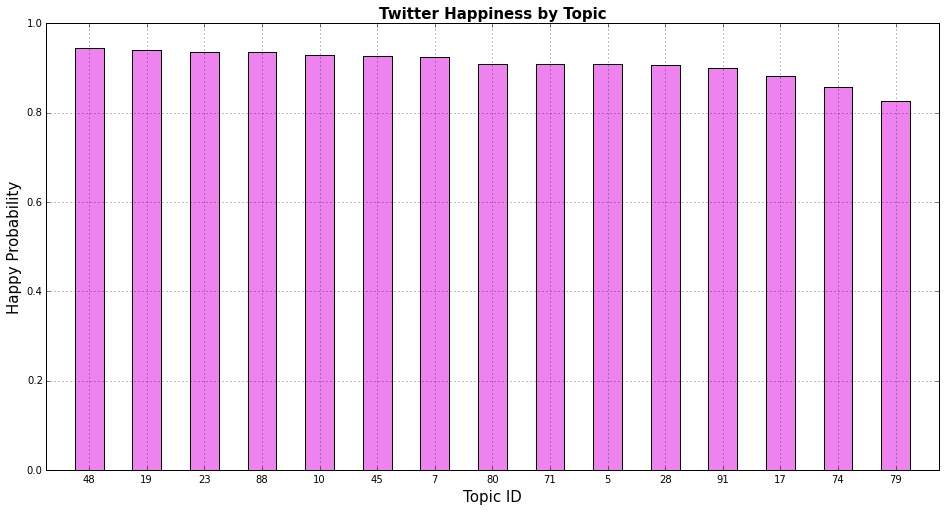

In [54]:
index = np.arange(len(best_topics_ids))
happy_probs_by_topic = np.array([topic_sent_dict[idx][0] for idx in best_topics_ids])
order = np.argsort(happy_probs_by_topic)[::-1]
width = 0.5
fig, ax = plt.subplots(figsize=(16,8))
plt.bar(index, happy_probs_by_topic[order], width, alpha=1, color='violet')
# Setting axis labels and ticks
ax.set_xlim((-width, len(best_topics_ids)))
ax.set_ylabel('Happy Probability', fontsize=15)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_title('Twitter Happiness by Topic', fontsize=15, fontweight='bold')
ax.set_xticks([i + 0.5 * width for i in index])
ax.set_xticklabels(np.array(best_topics_ids)[order])
plt.grid()
plt.show()

The airline-related topic that Twitter users are most positive about overall is the topic with ID 65, which is characterized by the terms "night", "help", "onboard", "receipt", "steward", and "speech". These tweets likely deal with experiences on the plane and interactions with flight attendants and other airline personnel.

The airline-related topic that Twitter users are _least_ positive about overall is the topic with ID 71, which is characterized by the terms "basket", "note", "bonus", "quality", and "concierge". Although this topic has a lower coherence score and thus does not correspond as clearly to a human-understandable concept, tweets about accommodations while traveling might be found in this topic.

We're less interested in what people think of different aspects of airlines overall than in how individual airlines score in each of these categories, though. Let's re-group our data by airline and topic and see how each airline stacks up on each topic.

In [55]:
airline_topics_sentiments = regrouped.map(lambda ((idx, air), (tpc, probs)): ((air, tpc), probs)).reduceByKey(weighted_avg_probs).mapValues(happy_sad_probs)
print airline_topics_sentiments.take(5)
air_tpc_sent_dict = airline_topics_sentiments.collectAsMap()

[(('united', 7), (0.9056254980141637, 0.094374501985836107)), (('spiritairlines', 10), (0.99220414952024172, 0.0077958504797583043)), (('spiritairlines', 74), (0.77847813972636815, 0.22152186027363194)), (('delta', 91), (0.8953881213299999, 0.10461187866999992)), (('united', 23), (0.91374004754232929, 0.086259952457670458))]


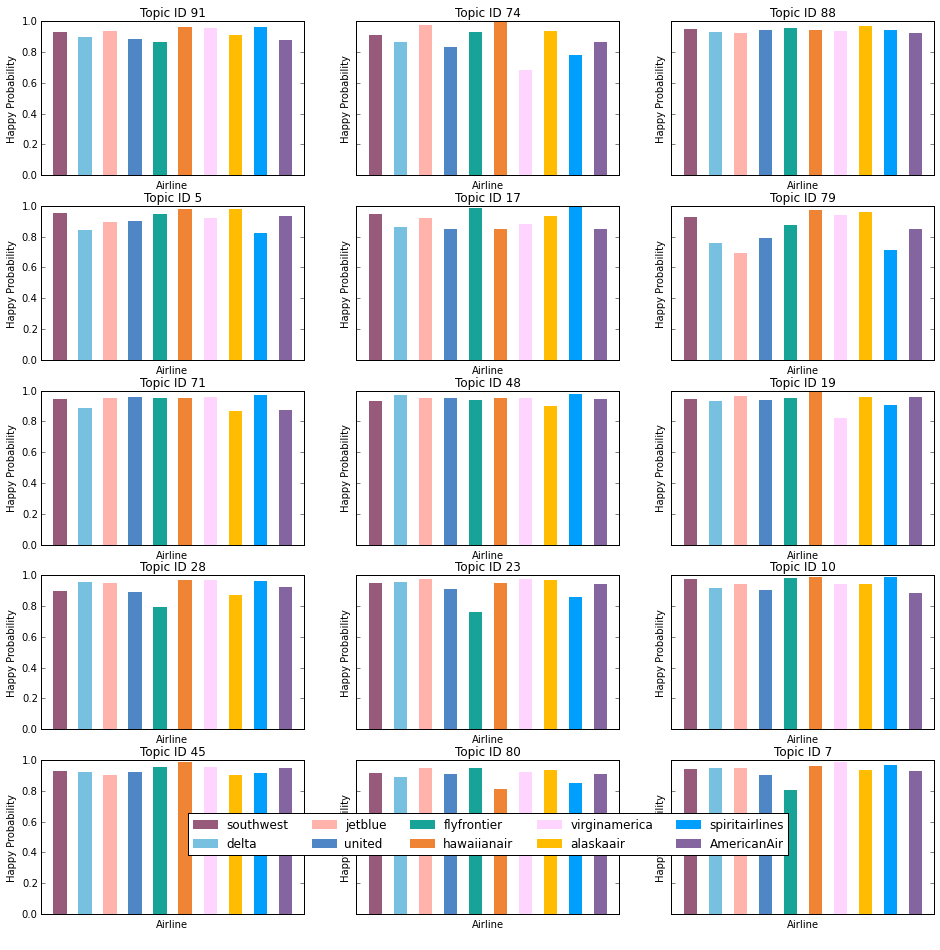

In [61]:
index = np.arange(len(airlines))
colors = ['#975A7A', '#78C0E0', '#FFB3AA', '#4F86C6', '#17A398', '#EE8434', '#FFD5FF', '#FFBC00', '#009FFD', '#8565A0']
fig, axes = plt.subplots(5, 3, figsize=(16,16), sharex=True, sharey=True)
for tpc, ax in zip(best_topics_ids, axes.ravel()):
    happy_probs_by_airline = [air_tpc_sent_dict.get((air, tpc), [0])[0] for air in airlines]
    width = 0.5
    barlist = ax.bar(index, happy_probs_by_airline, width, alpha=1)
    for bar, color in zip(barlist, colors):
        bar.set_color(color)
    # Setting axis labels and ticks
    ax.set_xlim((-width, len(airlines)))
    ax.set_ylabel('Happy Probability')
    ax.set_xlabel('Airline')
    ax.set_title('Topic ID {}'.format(tpc))
    ax.set_xticks([])
fig.legend(barlist, airlines, loc=(0.2,0.1), ncol=5)
plt.show()